# Time Series

> Data diperoleh dari Kaggle

In [16]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [17]:
!kaggle datasets download -d shree1992/bitcoin-historical-price

bitcoin-historical-price.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
import os
import zipfile

In [19]:
local_zip = '/content/bitcoin-historical-price.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [66]:
import pandas as pd
df = pd.read_csv('/content/Bitcoin_Historical_Price.csv')
df.tail()

,Date,Close
1767,27-02-2018,10397.9
1768,28-02-2018,10951.0
1769,01-03-2018,11086.4
1770,02-03-2018,11489.7
1771,03-03-2018,11512.6


In [67]:
df.isnull().sum()

Date     0
Close    0
dtype: int64

In [68]:
df.shape

(1772, 2)

In [69]:
date = df['Date'].values
date

array(['27-04-2013', '28-04-2013', '29-04-2013', ..., '01-03-2018',
       '02-03-2018', '03-03-2018'], dtype=object)

In [70]:
price = df['Close'].values
price

array([  134.21,   144.54,   139.  , ..., 11086.4 , 11489.7 , 11512.6 ])

In [71]:
from sklearn.model_selection import train_test_split
date_train, date_test, price_train, price_test = train_test_split(date, price, test_size=0.2)

Text(0.5, 0, 'Waktu')

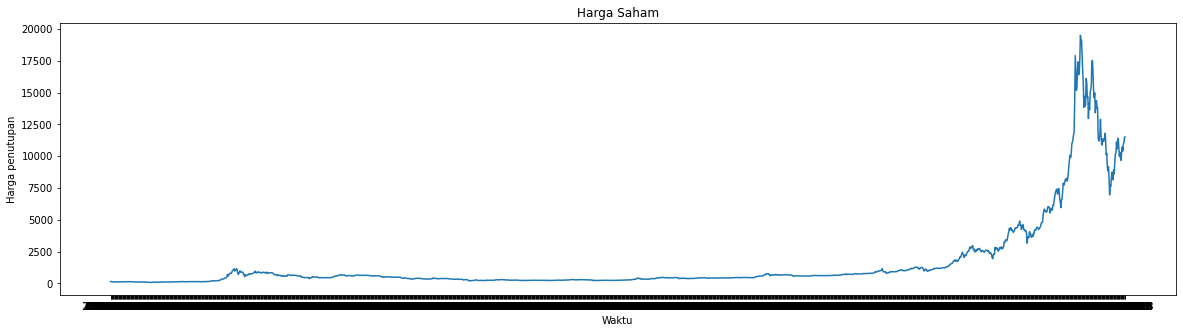

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(date, price)
plt.title("Harga Saham")
plt.ylabel('Harga penutupan')
plt.xlabel('Waktu')

In [73]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [74]:
# window dibuat per bulan (30 hari)
import tensorflow as tf

train_set = windowed_dataset(price_train, window_size=30, batch_size=128, shuffle_buffer=100)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [75]:
test_set = windowed_dataset(price_test, window_size=30, batch_size=128, shuffle_buffer=100)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [76]:
optimizer = tf.keras.optimizers.SGD(lr=0.3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100,validation_data=test_set)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 2s 142ms/step - loss: 1714.1929 - mae: 1714.6929 - val_loss: 1491.6260 - val_mae: 1492.1260
Epoch 2/100
11/11 [==============================] - 1s 80ms/step - loss: 1998.7822 - mae: 1999.2822 - val_loss: 1501.3044 - val_mae: 1501.8044
Epoch 3/100
11/11 [==============================] - 1s 74ms/step - loss: 1500.8344 - mae: 1501.3344 - val_loss: 1472.2394 - val_mae: 1472.7394
Epoch 4/100
11/11 [==============================] - 1s 78ms/step - loss: 1

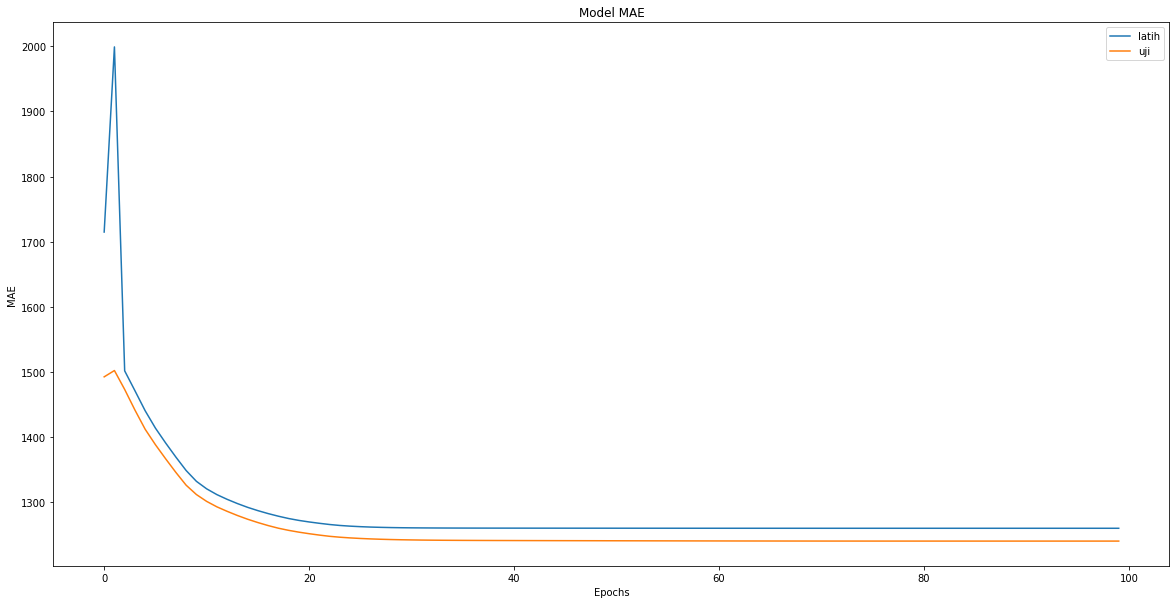

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['latih', 'uji'], loc='upper right')
plt.show()

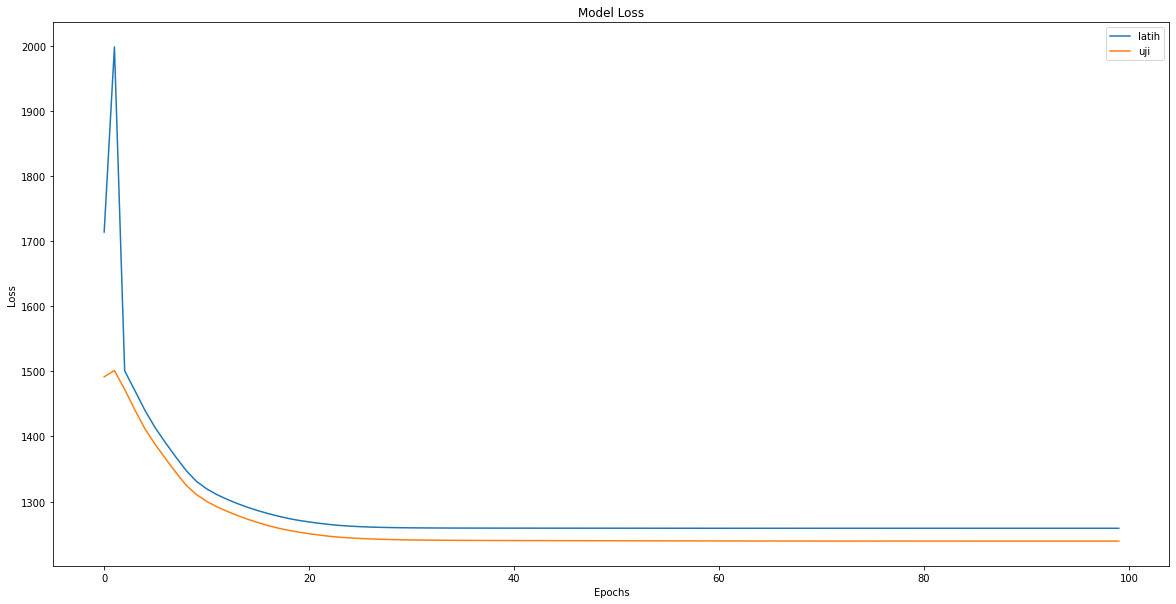

In [78]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['latih', 'uji'], loc='upper right')
plt.show()